In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.66MB/s]


In [ ]:
LATENT_DIM = 32

###implementing the VAE
- DECODER
- ENCODER
- VAE


In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log-variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [5]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL divergence between learned distribution and standard normal
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
from sklearn.decomposition import PCA

In [12]:
def train_vae(plot = True):


    epochs = 15
    latent_dim = 64  # For visualization

    # Model
    vae = VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=1e-4)

    # Training loop
    vae.train()
    for epoch in range(1, epochs + 1):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch}, Average loss: {train_loss / len(train_loader.dataset):.4f}')

    # --- Visualization ---
    vae.eval()
    # 1. Visualize reconstructions
    with torch.no_grad():
        test_batch, _ = next(iter(test_loader))
        test_batch = test_batch.to(device)
        recon_batch, _, _ = vae(test_batch)
        n = 8
        plt.figure(figsize=(16, 4))
        for i in range(n):
            # Original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(test_batch[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')
            # Reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_batch[i].cpu().view(28, 28), cmap='gray')
            plt.axis('off')
        plt.suptitle('Top: Original, Bottom: Reconstruction')
        plt.show()
    # Get latent vectors and labels for test set
    vae.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            mu, logvar = vae.encode(data.view(-1, 784))
            latents.append(mu.cpu().numpy())


            labels.append(target.numpy())
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
        # PCA and plot
    if plot:
        pca = PCA(n_components=2)
        latents_2d = pca.fit_transform(latents)
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=2, alpha=0.7)
        plt.colorbar(scatter, ticks=range(10), label='Digit label')
        plt.title('MNIST VAE Latent Space (PCA to 2D)')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.tight_layout()
        plt.show()



Epoch 1, Average loss: 225.3238
Epoch 2, Average loss: 165.3664
Epoch 3, Average loss: 151.4242
Epoch 4, Average loss: 142.4113
Epoch 5, Average loss: 136.2391
Epoch 6, Average loss: 131.7173
Epoch 7, Average loss: 128.1701
Epoch 8, Average loss: 125.3394
Epoch 9, Average loss: 123.0061
Epoch 10, Average loss: 120.9981
Epoch 11, Average loss: 119.3338
Epoch 12, Average loss: 117.9294
Epoch 13, Average loss: 116.6566
Epoch 14, Average loss: 115.5640
Epoch 15, Average loss: 114.5881


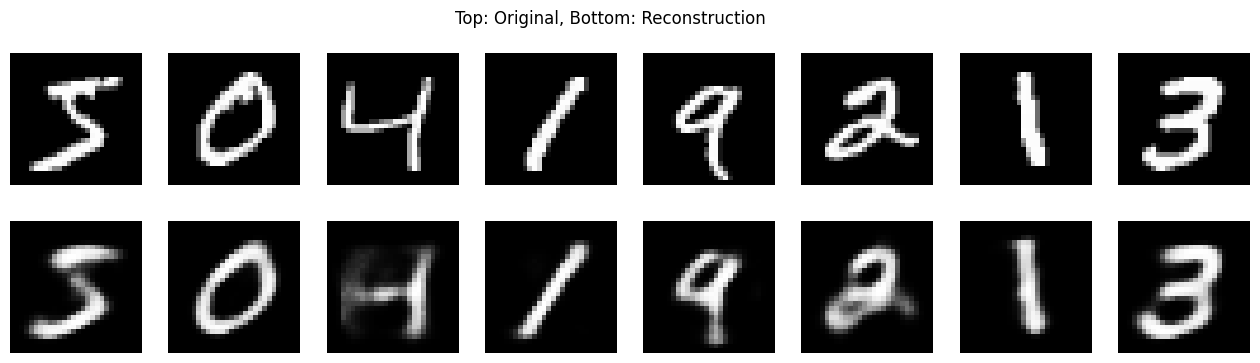

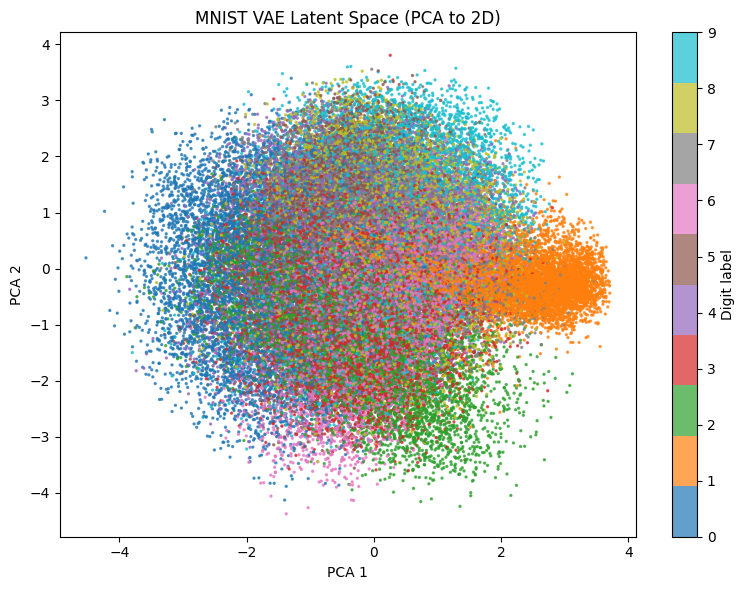

In [13]:
train_vae()